In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [6]:
METRIC = "systemic_failure"

In [7]:
df = pd.read_csv("../data/acs_results/acs_results_conformal.csv")
CONFORMAL = True
N_TRAIN = 2588885
MIN_DATA_SCALE = int(N_TRAIN/10)
PARTITIONS_DATA_SCALE = MIN_DATA_SCALE
df["data_scale"] = (N_TRAIN/df["data_scale"]).astype(int)
df = df[df["num_models"]<=5]

df = df.drop(columns=["random_seed", "task_type"])
df = df.groupby(["exp_type", "random_distance", "num_models", "data_scale", "method"]).mean().reset_index(drop=False)

In [8]:
def table_by_models(data, metric, exp_type="baseline", method="lockout", data_scale=MIN_DATA_SCALE):
    df = data
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["num_models", "random_distance", metric]]
    df = df[df["num_models"]>1]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["num_models"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["num_models"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [9]:
def table_by_data(data, metric, exp_type="baseline", method="lockout", num_models=2):
    df = data
    df = df[df["num_models"]==num_models]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["data_scale", "random_distance", metric]]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["data_scale"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["data_scale"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [10]:
def table_by_fairness(data, metrics):
    df = data
    df = df[df["method"]=="lockout"]
    df = df[df["exp_type"]=="baseline"]
    df = df[df["num_models"]==5]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    
    cols = ["random_distance"]
    for m in metrics:
        cols.append(m+"_0")
        cols.append(m+"_1")
    return df[cols].reset_index(drop=True).round(3)

In [11]:
def plot(data, metric, xaxis, exp_type="baseline", method="lockout", ylog=False, ylim=None, save=False):
    plt.rcParams["figure.figsize"] = [7,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[df[xaxis]>1]
    df = df[df["num_models"]<=5]

    if CONFORMAL:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*--', color='black', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#fc2847', label="Alpha = 0.1")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#ffa343', label="Alpha = 0.2")
        plt.plot(df.loc[df["random_distance"]==0.25, xaxis], df.loc[df["random_distance"]==0.25, metric], '*-', color='#deca57', label="Alpha = 0.25")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#71bc78', label="Alpha = 0.3")
        plt.plot(df.loc[df["random_distance"]==0.35, xaxis], df.loc[df["random_distance"]==0.35, metric], '*-', color='#0f4c81', label="Alpha = 0.35")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#7442c8', label="Alpha = 0.4")
        plt.plot(df.loc[df["random_distance"]==0.5, xaxis], df.loc[df["random_distance"]==0.5, metric], '*-', color='#fb7efd', label="Alpha = 0.5")

    else:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*--', color='green', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#fc2847', label="Random(0.4,0.6)")
        plt.plot(df.loc[df["random_distance"]==0.15, xaxis], df.loc[df["random_distance"]==0.15, metric], '*-', color='#ffa343', label="Random(0.35,0.65)")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#deca57', label="Random(0.3,0.7)")
        plt.plot(df.loc[df["random_distance"]==0.25, xaxis], df.loc[df["random_distance"]==0.25, metric], '*-', color='#71bc78', label="Random(0.25,0.75)")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#0f4c81', label="Random(0.2,0.8)")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#7442c8', label="Random(0.1,0.9)")
        plt.plot(df.loc[df["random_distance"]==0.5, xaxis], df.loc[df["random_distance"]==0.5, metric], '*-', color='#fb7efd', label="Random(0,1)")


    if ylim:
        plt.ylim(ylim)
    if ylog:
        plt.yscale('log')   

    plt.xlabel(xaxis)
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    plt.show()

In [12]:
def plot_by_threshold(data, metric, num_models=2, method="lockout", exp_type="baseline"):
    plt.rcParams["figure.figsize"] = [5.5, 3]
    fig, ax = plt.subplots()
    
    df = data
    df = df[df["method"]==method]
    df = df[df["num_models"]==num_models]

    plt.plot(df.loc[df["exp_type"]==exp_type, "random_distance"], df.loc[df["exp_type"]==exp_type, metric], '*-', color='black')

    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")
    
    plt.ylabel(metric)
    fig.tight_layout()
    plt.show()

In [13]:
def plot_summary(data, metric, num_models=2, method="lockout", diff=False):
    plt.rcParams["figure.figsize"] = [8, 3]
    fig, ax = plt.subplots()
    
    df = data
    df = df[df["method"]==method]
    df = df[df["num_models"]==num_models]
    
    base = df[df["random_distance"]==0]
    base["base"] = base[metric]
    base["base_accuracy"] = base["accuracy"]
    base = base[["base", "base_accuracy", "exp_type"]]
    df = df.merge(base, on=["exp_type"], how="left")
    
    if diff:
        df[metric] = df[metric]-df["base"]
        df["accuracy"] = df["accuracy"]-df["base_accuracy"]
        #plt.plot(df.loc[df["exp_type"]=="all", "random_distance"], df.loc[df["exp_type"]=="baseline", "accuracy"], '*--', color='#FF7276', label="Accuracy")

    plt.plot(df.loc[df["exp_type"]=="baseline", "random_distance"], df.loc[df["exp_type"]=="baseline", metric], '*-', color='black', label="Baseline")
    #plt.plot(df.loc[df["exp_type"]=="data_partitions", "random_distance"], df.loc[df["exp_type"]=="data_partitions", metric], '*-', color='#002f70', label="Different Data")
    plt.plot(df.loc[df["exp_type"]=="models", "random_distance"], df.loc[df["exp_type"]=="models", metric], '*-', color='#004fbf', label="Different Model Class")
    #plt.plot(df.loc[df["exp_type"]=="features", "random_distance"], df.loc[df["exp_type"]=="features", metric], '*-', color='#0068f9', label="Different Features")
    plt.plot(df.loc[df["exp_type"]=="all", "random_distance"], df.loc[df["exp_type"]=="all", metric], '*-', color='#00a6f9', label="All Different\n(Data, Model, Features)")
    
    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")

    plt.title("System of "+str(num_models)+" Models")
    if diff:
        plt.ylabel("Difference in " + metric)
    else:
        plt.ylabel(metric)

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    plt.show()

In [14]:
def plot_fairness(data, metrics=[],labels=[], exp_type="baseline", method="lockout"):
    plt.rcParams["figure.figsize"] = [5.5,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[df["num_models"]==5]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    
    metric_lines = []
    class_lines = []
    colors = ["blue", "green", "red"]
    for i,m in enumerate(metrics):
        lin1, = plt.plot(df["random_distance"], df[m+"_0"], '*--', color=colors[i])
        lin2, = plt.plot(df["random_distance"], df[m+"_1"], '*-', color=colors[i])
        if i==0:
            class_lines.append(lin1)
            class_lines.append(lin2)
        metric_lines.append(lin2)
    
    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")
        
    legend1 = plt.legend(class_lines, ["Minority Class", "Majority Class"], bbox_to_anchor=(1.05, 0.25), loc='upper left')
    plt.legend(metric_lines, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.gca().add_artist(legend1)

In [15]:
def plot_tasks(data, metric, method="lockout", num_tasks=2):
    plt.rcParams["figure.figsize"] = [5,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]=="tasks"]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    df = df[df["num_models"]==num_tasks]

    plt.bar(np.array(df["random_distance"]), np.array(df[metric]), width=0.02)

    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")
        
    plt.ylabel(metric)
    
    fig.tight_layout()
    plt.show()

In [16]:
def table_by_models(data, metric, exp_type="baseline", method="lockout", data_scale=MIN_DATA_SCALE):
    df = data
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["num_models", "random_distance", metric]]
    df = df[df["num_models"]>1]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["num_models"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["num_models"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

# Results -- Accuracy

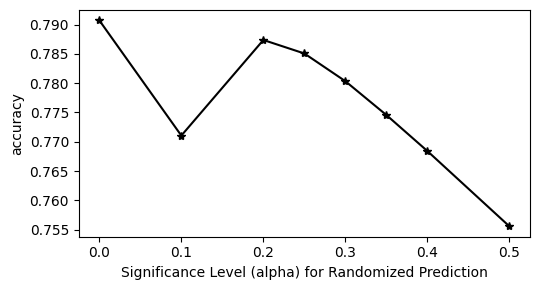

In [17]:
plot_by_threshold(df, "accuracy", 5)

In [18]:
table_by_models(df, "accuracy")[["random_distance", "5"]].rename(columns={'5':"accuracy"})

,random_distance,accuracy
0,0.00,0.791
1,0.10,0.771
2,0.20,0.787
3,0.25,0.785
4,0.30,0.780
5,0.35,0.775
6,0.40,0.768
7,0.50,0.756


### Acceptance Rate 

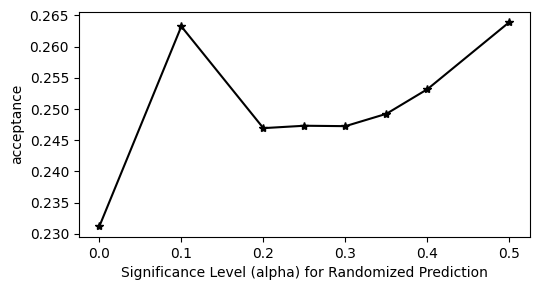

In [19]:
plot_by_threshold(df, "acceptance", 5)

# Results -- Homogenization As Repeated Inaccurate Decisions

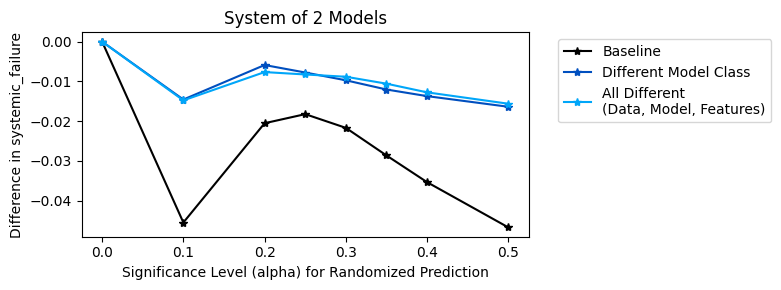

In [20]:
plot_summary(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, 2, "inaccurate", True)

### Baseline: Homogenization Across Same Model Class + Training Data + Feature Set

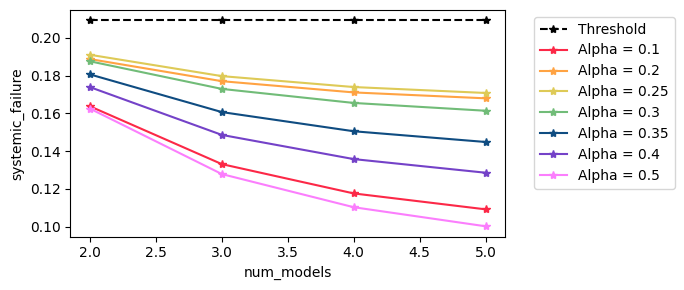

In [21]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "baseline", "inaccurate")

In [22]:
table_by_models(df, METRIC, "baseline", "inaccurate")

,random_distance,2,3,4,5
0,0.00,0.209,0.209,0.209,0.209
1,0.10,0.164,0.133,0.118,0.109
2,0.20,0.189,0.177,0.171,0.168
3,0.25,0.191,0.180,0.174,0.171
4,0.30,0.188,0.173,0.166,0.161
5,0.35,0.181,0.161,0.151,0.145
6,0.40,0.174,0.149,0.136,0.129
7,0.50,0.162,0.128,0.110,0.100


### Homogenization Across Different Model Class + Training Data + Feature Set

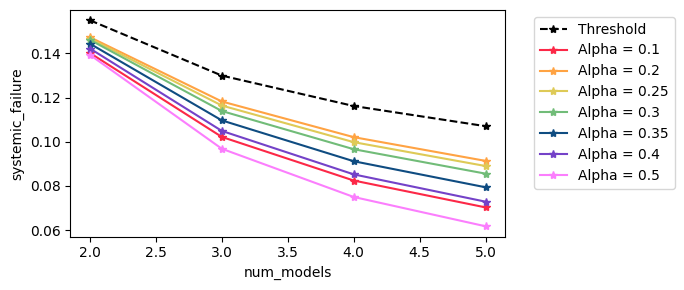

In [23]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "all", "inaccurate")

In [24]:
table_by_models(df, METRIC, "all", "inaccurate")

,random_distance,2,3,4,5
0,0.00,0.155,0.130,0.116,0.107
1,0.10,0.140,0.102,0.082,0.070
2,0.20,0.147,0.118,0.102,0.091
3,0.25,0.147,0.116,0.100,0.089
4,0.30,0.146,0.114,0.097,0.086
5,0.35,0.144,0.110,0.091,0.079
6,0.40,0.142,0.105,0.085,0.073
7,0.50,0.139,0.097,0.075,0.062


# Results -- Homogenization As Repeated Negative Decisions

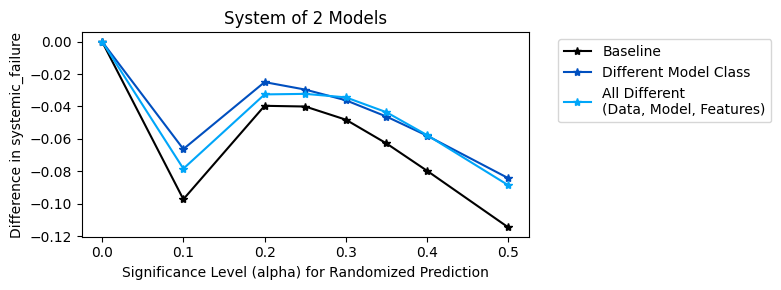

In [25]:
plot_summary(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, 2, "lockout", True)

### Baseline: Homogenization Across Same Model Class + Training Data + Feature Set

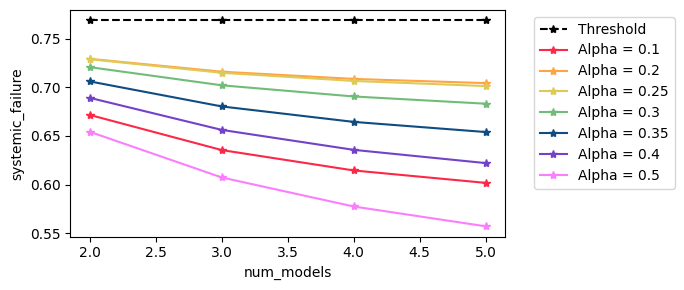

In [26]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "baseline", "lockout")

In [27]:
table_by_models(df, METRIC, "baseline", "lockout")

,random_distance,2,3,4,5
0,0.00,0.769,0.769,0.769,0.769
1,0.10,0.672,0.635,0.614,0.602
2,0.20,0.729,0.716,0.709,0.704
3,0.25,0.729,0.715,0.706,0.701
4,0.30,0.721,0.702,0.691,0.683
5,0.35,0.706,0.680,0.664,0.654
6,0.40,0.689,0.656,0.636,0.622
7,0.50,0.654,0.607,0.577,0.557


### Homogenization Across Different Model Class + Training Data + Feature Set

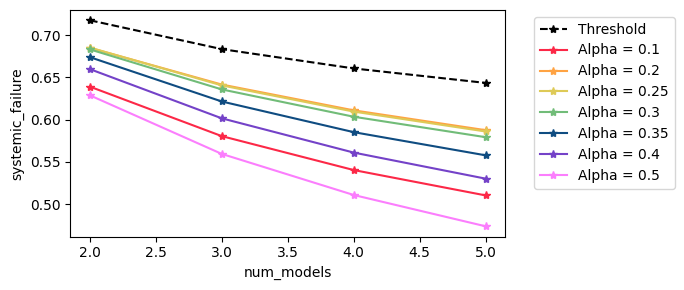

In [29]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "all", "lockout")

In [30]:
table_by_models(df, METRIC, "all", "lockout")

,random_distance,2,3,4,5
0,0.00,0.717,0.683,0.661,0.643
1,0.10,0.639,0.581,0.540,0.511
2,0.20,0.685,0.641,0.611,0.588
3,0.25,0.685,0.640,0.610,0.586
4,0.30,0.683,0.636,0.603,0.579
5,0.35,0.674,0.621,0.585,0.558
6,0.40,0.660,0.602,0.561,0.530
7,0.50,0.629,0.560,0.511,0.474


# Results -- Group Fairness Metrics

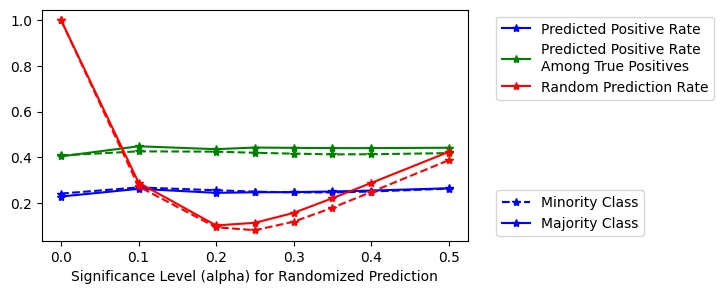

In [31]:
plot_fairness(df, ["pred_pos", "true_pos", "random"], ["Predicted Positive Rate",
                                    "Predicted Positive Rate\nAmong True Positives",
                                    "Random Prediction Rate"])

In [32]:
table_by_fairness(df, ["random", "pred_pos", "true_pos"])

,random_distance,random_0,random_1,pred_pos_0,pred_pos_1,true_pos_0,true_pos_1
0,0.00,1.000,1.000,0.241,0.228,0.408,0.404
1,0.10,0.272,0.289,0.268,0.262,0.426,0.448
2,0.20,0.094,0.102,0.256,0.244,0.425,0.435
3,0.25,0.081,0.113,0.249,0.247,0.420,0.443
4,0.30,0.118,0.156,0.246,0.248,0.416,0.441
5,0.35,0.179,0.221,0.246,0.250,0.413,0.440
6,0.40,0.248,0.287,0.250,0.254,0.413,0.440
7,0.50,0.387,0.423,0.263,0.264,0.418,0.442


# Results -- Distribution of Risk Scores

In [33]:
df = pd.read_csv("../data/acs_results/acs_risk.csv")

In [34]:
c0, b0 = np.histogram(df.loc[df["threshold"]==0, "risk_score"], 50)
c1, b1 = np.histogram(df.loc[(df["threshold"]==0.1), "risk_score"], 50)
c2, b2 = np.histogram(df.loc[(df["threshold"]==0.2), "risk_score"], 50)
c25, b25 = np.histogram(df.loc[(df["threshold"]==0.25), "risk_score"], 50)
c3, b3 = np.histogram(df.loc[(df["threshold"]==0.3), "risk_score"], 50)
c35, b35 = np.histogram(df.loc[(df["threshold"]==0.35), "risk_score"], 50)
c4, b4 = np.histogram(df.loc[(df["threshold"]==0.4), "risk_score"], 50)
c5, b5 = np.histogram(df.loc[(df["threshold"]==0.5), "risk_score"], 50)

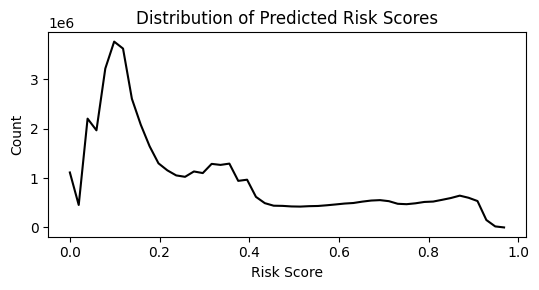

In [35]:
plt.rcParams["figure.figsize"] = [5.5,3]
fig, ax = plt.subplots()


ax.plot(b0[:-1], c0, color='black')

plt.ylabel("Count")
plt.xlabel("Risk Score")
plt.title("Distribution of Predicted Risk Scores")
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout()

plt.show()
#fig.savefig('risk.jpg')

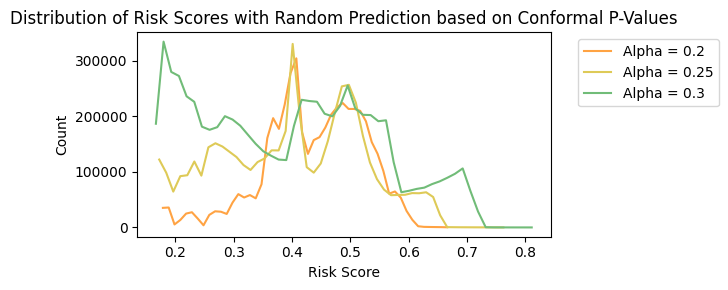

In [36]:
plt.rcParams["figure.figsize"] = [7,3]
fig, ax = plt.subplots()


#ax.plot(b1[:-1], c1, color='#fc2847', label="Alpha = 0.1")
ax.plot(b2[:-1], c2, color='#ffa343', label="Alpha = 0.2")
ax.plot(b25[:-1], c25, color='#deca57', label="Alpha = 0.25")
ax.plot(b3[:-1], c3, color='#71bc78', label="Alpha = 0.3")
#ax.plot(b35[:-1], c35, color='#0f4c81', label="Alpha = 0.35")
#ax.plot(b4[:-1], c4, color='#7442c8', label="Alpha = 0.4")
#ax.plot(b5[:-1], c5, color='#fb7efd', label="Alpha = 0.5")

plt.ylabel("Count")
plt.xlabel("Risk Score")
plt.title("Distribution of Risk Scores with Random Prediction based on Conformal P-Values")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout()

plt.show()
#fig.savefig('risk.jpg')